In [ ]:
### To-Do
# X) work out math if extra treatment needed for lumi normalization
# 1) plot some variables before and after normalization. how do they compare?
# X) try batch normalization in the network? re-do step1 maybe?
# 3) to_categorical for signal and background preds?
# 4) grid optimization? --> dropout rate, layers, nodes, etc
# X) k-fold validation

In [1]:
# Import the needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.utils import normalize, to_categorical
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# Fix random seed for reproducibility
seed = 7
np.random.seed(seed)

Using TensorFlow backend.


In [2]:
import sys
sys.path.insert(0, '/home/btannenw/Desktop/ML/dihiggsMLProject/')
from utils.commonFunctions import *

In [3]:
#*** 1. Import data and check stuff
testingFraction = 0.3

# *** A. Import Dataset
hh_raw, qcd_raw = importDatasets()

# *** 2. Make mix of dihiggs and QCD for specified variables
#variables_top10 = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'hh_mass', 'h1_mass', 'h2_mass','hh_pt', 'h1_pt', 'h2_pt', 'scalarHT']
variables_top10 = list(qcd_raw.columns.values)
variables_top10.remove('isSignal')
variables_top10.remove('isMatchable')

top10_data_train, top10_data_test, top10_labels_train, top10_labels_test = makeTestTrainSamplesWithUserVariables(hh_raw, qcd_raw, variables_top10, testingFraction)


N_sig = 78876 , N_bkg = 116481
195357 rows of total data with  195357 labels [Train+Test]
136749 rows of training data with  136749 labels [Train]
58608 rows of testing data with  58608 labels [Test]


In [4]:
# *** 2. Split testing data and normalize data inputs
top10_data_train__norm = normalize(top10_data_train, axis=1)
top10_data_test__norm = normalize(top10_data_test, axis=1)

#top10_labels_train = to_categorical(top10_labels_train)
#top10_labels_test = to_categorical(top10_labels_test)


In [5]:
# *** 3A. Define NN model and train
nInputNodes = len(top10_data_train__norm.columns) # = 53 for all variables, other configurations will vary

model = Sequential()
model.add(Dense(100, input_dim=nInputNodes, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
#model.add(BatchNormalization())

model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
#model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(top10_data_train__norm, top10_labels_train, epochs=25, validation_split=0.25, batch_size=400)


Train on 102561 samples, validate on 34188 samples
Epoch 1/25
102561/102561 [==============================] - 3s 31us/step - loss: 0.6095 - accuracy: 0.6562 - val_loss: 0.6520 - val_accuracy: 0.6749
Epoch 2/25
102561/102561 [==============================] - 3s 31us/step - loss: 0.5748 - accuracy: 0.6898 - val_loss: 0.5987 - val_accuracy: 0.6950
Epoch 3/25
102561/102561 [==============================] - 2s 18us/step - loss: 0.5627 - accuracy: 0.7016 - val_loss: 0.5538 - val_accuracy: 0.7107
Epoch 4/25
102561/102561 [==============================] - 2s 19us/step - loss: 0.5411 - accuracy: 0.7209 - val_loss: 0.5203 - val_accuracy: 0.7366
Epoch 5/25
102561/102561 [==============================] - 2s 18us/step - loss: 0.5219 - accuracy: 0.7384 - val_loss: 0.5094 - val_accuracy: 0.7464
Epoch 6/25
102561/102561 [==============================] - 2s 20us/step - loss: 0.5108 - accuracy: 0.7467 - val_loss: 0.5007 - val_accuracy: 0.7543
Epoch 7/25
102561/102561 [=============================

In [ ]:
plt.hist( hh_raw.nJets, bins=10)

In [ ]:
# *** 3B. Define k-fold NN model and train
nInputNodes = len(top10_data_train__norm.columns) # = 53 for all variables, other configurations will vary
kFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
crossVal_scores = []

X = np.array(top10_data_train__norm)
Y = np.array(top10_labels_train)

for train, test in kFold.split(X, Y):
  # create model
    k_model = Sequential()
    k_model.add(Dense(50, input_dim= nInputNodes, activation='relu'))
    #k_model.add(Dropout(0.2))
    k_model.add(BatchNormalization())

    k_model.add(Dense(25, activation='relu'))
    k_model.add(Dense(12, activation='relu'))
    #k_model.add(Dense(8, activation='relu'))
    k_model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    k_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Fit the model
    k_model.fit(X[train], Y[train], epochs=50, batch_size=400, verbose=0)
    
    # Evaluate the model
    scores = k_model.evaluate(X[test], Y[test], verbose=0)
    print("%s: %.2f%%" % (k_model.metrics_names[1], scores[1]*100))
    crossVal_scores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(crossVal_scores), np.std(crossVal_scores)))

In [21]:
# *** 4. Do some very specific evaluation based on pure samples
hh_data_test, hh_labels_test, qcd_data_test, qcd_labels_test = returnTestSamplesSplitIntoSignalAndBackground(top10_data_test__norm, top10_labels_test)

#top10_data_test__norm['isSignal'] = top10_labels_test
#hh_data_test = top10_data_test__norm[ top10_data_test__norm.isSignal==1 ]
#qcd_data_test = top10_data_test__norm[ top10_data_test__norm.isSignal==0 ]
#hh_labels_test = hh_data_test.isSignal
#qcd_labels_test = qcd_data_test.isSignal
#hh_data_test = hh_data_test.drop('isSignal', axis=1)
#qcd_data_test = qcd_data_test.drop('isSignal', axis=1)

score_hh = model.evaluate(hh_data_test, hh_labels_test)
score_qcd = model.evaluate(qcd_data_test, qcd_labels_test)
print(score_hh, score_qcd)
pred_hh = model.predict(hh_data_test)
pred_qcd = model.predict(qcd_data_test)

35007/35007 [==============================] - 1s 26us/step
[0.5932906565284948, 0.6775984168052673] [0.34619553023351474, 0.867083728313446]


In [22]:
model.count_params()
#model_confusionMatrix = confusion_matrix(hh_data_test, hh_labels_test)
#print(cm)


20651

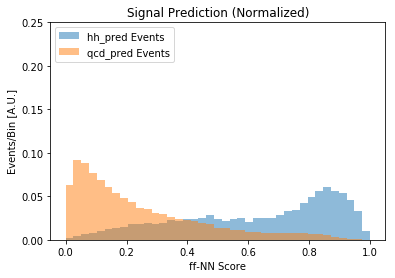

In [23]:
_nBins = 40
predictionResults = {'hh_pred':pred_hh, 'qcd_pred':pred_qcd}
compareManyHistograms( predictionResults, ['hh_pred', 'qcd_pred'], 2, 'Signal Prediction', 'ff-NN Score', 0, 1, _nBins, _yMax = 5, _normed=True, _savePlot=False )


In [24]:
# *** 4. Get best cut value for ff-NN assuming some minimal amount of signal
returnBestCutValue('ff-NN', pred_hh.copy(), pred_qcd.copy(), _minBackground=200, _testingFraction=testingFraction)

23601 35007
nSig = [1506.1896] , nBkg = [1016291.8] with significance = [1.49406824] for ff-NN score > [0.8464459]


(array([1.49406824]), array([0.8464459], dtype=float32))

In [ ]:
# *** 5. Get signifiance for any user-specified NN score cut value
lumiscale_hh  = getLumiScaleFactor(testingFraction, True)
lumiscale_qcd = getLumiScaleFactor(testingFraction, False)
cut = 0.81
_nSignal = sum( value > cut for value in pred_hh)*lumiscale_hh
_nBackground = sum( value > cut for value in pred_qcd)*lumiscale_qcd

print('nSig = {0} , nBkg = {1} with significance = {2} for NN score > {3}'.format(_nSignal, _nBackground, _nSignal/np.sqrt(_nBackground), cut) )

In [6]:
import pickle
pickle.dump(model, open('models/allVars_100-50-50.pkl', 'wb'))


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


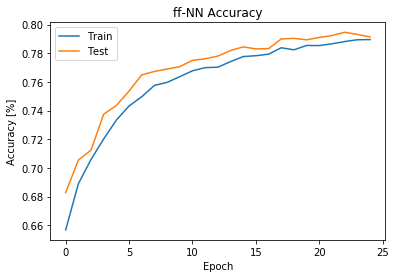

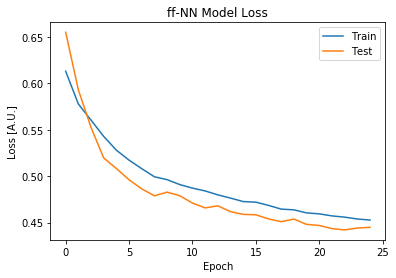

In [25]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ff-NN Accuracy')
plt.ylabel('Accuracy [%]')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ff-NN Model Loss')
plt.ylabel('Loss [A.U.]')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               12600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)               

In [ ]:
# ROC curve and AUC
top10_data_test_ROC = top10_data_test__norm.copy()
top10_data_test_ROC = top10_data_test_ROC.drop('isSignal', axis=1)

y_pred = model.predict(top10_data_test_ROC).ravel()
falsePositiveRate, truePositiveRate, thresholds = roc_curve(top10_labels_test, y_pred)
auc_keras = auc(falsePositiveRate, truePositiveRate)

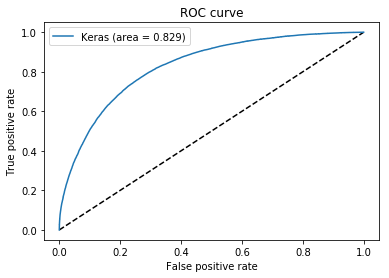

In [31]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(falsePositiveRate, truePositiveRate, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()